Objective            : A mobile retail company wants to prevent customer churn. this company asked ds team to creat prediction model about customer churn.

# **Import Library**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
!pip install phik
!pip install feature_engine
import phik
import sklearn
import joblib
import pickle


from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import confusion_matrix ,accuracy_score, roc_curve,roc_auc_score,precision_score, recall_score, classification_report, f1_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

# **Data Loading**

In [2]:
#load dataset
df = pd.read_csv('churn.csv')
pd.set_option('display.max_columns', None)
df.head()

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,9f420209e7d129f3,29,F,NaN,No Membership,2017-04-05,Yes,Without Offers,NaN,Wi-Fi,22:29:49,4,1184.49,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Poor Website,1
1,ac6e97806267549e,50,M,NaN,Basic Membership,2017-03-31,Yes,Without Offers,Desktop,Fiber_Optic,15:44:56,11,338.15,7665.66,17.0,575.97,Yes,No,Yes,No Information Available,Poor Customer Service,1
2,a6aa19b1580eed4e,26,F,City,Silver Membership,2017-02-11,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,20:31:53,8,235.14,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0
3,aeee343277211c2f,63,F,Village,No Membership,2015-12-23,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,14:28:05,10,56.67,15678.14,11.0,590.22,No,Yes,No,Not Applicable,Too many ads,1
4,82448b5c8ce6390c,64,M,Town,Silver Membership,2015-03-20,NaN,Gift Vouchers/Coupons,Smartphone,Wi-Fi,04:16:48,9,153.99,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Poor Product Quality,0


## Dataset Description

| Column | Description |
| --- | --- |
| `user_id` | ID of a customer |
| `age` | Age of a customer |
| `gender` | Gender of a customer |
| `region_category` | Region that a customer belongs to |
| `membership_category` | Category of the membership that a customer is using |
| `joining_date` | Date when a customer became a member |
| `joined_through referral` | Whether a customer joined using any referral code or ID |
| `preferred_offer types` | Type of offer that a customer prefers |
| `medium_of operation` | Medium of operation that a customer uses for transactions |
| `internet_option` | Type of internet service a customer uses |
| `last_visit_time` | The last time a customer visited the website |
| `days_since_last_login` | Number of days since a customer last logged into the website |
| `avg_time_spent` | Average time spent by a customer on the website |
| `avg_transaction_value` | Average transaction value of a customer |
| `avg_frequency_login_days` | Number of times a customer has logged in to the website |
| `points_in_wallet` | Points awarded to a customer on each transaction |
| `used_special_discount` | Whether a customer uses special discounts offered |
| `offer_application_preference` | Whether a customer prefers offers |
| `past_complaint` | Whether a customer has raised any complaints |
| `complaint_status` | Whether the complaints raised by a customer was resolved |
| `feedback` | Feedback provided by a customer |
| `churn_risk_score` | Churn score <br><br> `0` : Not churn <br> `1` : Churn |

## Data Cleaning

In [3]:
#Get overview dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37010 entries, 0 to 37009
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       37010 non-null  object 
 1   age                           37010 non-null  int64  
 2   gender                        36951 non-null  object 
 3   region_category               31579 non-null  object 
 4   membership_category           37010 non-null  object 
 5   joining_date                  37010 non-null  object 
 6   joined_through_referral       31568 non-null  object 
 7   preferred_offer_types         36722 non-null  object 
 8   medium_of_operation           31615 non-null  object 
 9   internet_option               37010 non-null  object 
 10  last_visit_time               37010 non-null  object 
 11  days_since_last_login         37010 non-null  int64  
 12  avg_time_spent                37010 non-null  float64
 13  a

This data contains 37010 rows and 22 columns that consists of 4 float columns, 3 integer columns, and 15 string columns. As we see from the overview, several columns has null values.

In this data, there are date-time columns but detected as string. we want to change the data type in `joining_date` and `last_visit_time` to date-time format and then extract year and hour.

In [4]:
#change to date format
df['joining_date'] = pd.to_datetime(df['joining_date'])

#extract year
df['joining_date'] = df['joining_date'].dt.year

In [5]:
#change to time format
df['last_visit_time'] = pd.to_datetime(df['last_visit_time'], format='%H:%M:%S')

#extract hour
df['last_visit_time'] = df['last_visit_time'].dt.hour

at `feedback` columns, we can group the values to negative-positive feedback to distinguish values and simplify the encoding process later.

In [6]:
#see unique values from feedback
df.feedback.unique()

array(['Poor Website', 'Poor Customer Service', 'Too many ads',
       'Poor Product Quality', 'No reason specified',
       'Products always in Stock', 'Reasonable Price',
       'Quality Customer Care', 'User Friendly Website'], dtype=object)

In [7]:
#change values to negative-no reason specified-positive
df['feedback'].replace({'Poor Website':'Negative','Poor Customer Service':'Negative', 'Too many ads':'Negative', 'Poor Product Quality':'Negative',
                       'Products always in Stock':'Positive', 'Reasonable Price':'Positive', 'Quality Customer Care':'Positive', 'User Friendly Website':'Positive'}, inplace=True)

In [8]:
df['days_since_last_login'].replace({-999:31}, inplace=True)

### Missing Value

In [9]:
#check missing values
df.isna().sum()

user_id                            0
age                                0
gender                            59
region_category                 5431
membership_category                0
joining_date                       0
joined_through_referral         5442
preferred_offer_types            288
medium_of_operation             5395
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                   0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

we want to check the percentage of missing values to choose missing value handling methode.

In [10]:
#check null percentage
dfnull = df[['gender','region_category','joined_through_referral','preferred_offer_types','medium_of_operation']]

for i in dfnull:
    print(i)
    print('null percentage is:', dfnull[i].isnull().sum()/len(dfnull[i])*100)
    print('-'*30)


gender
null percentage is: 0.1594163739529857
------------------------------
region_category
null percentage is: 14.674412320994326
------------------------------
joined_through_referral
null percentage is: 14.704134017833018
------------------------------
preferred_offer_types
null percentage is: 0.7781680626857606
------------------------------
medium_of_operation
null percentage is: 14.577141313158606
------------------------------


the percentage of missing values, mostly are above 5%. because of that, we won't drop it. The method we use is imputing with mode or creating `unknown` values if imputing with mode method makes the data imbalance.

##### **gender**

In [11]:
#shows count of missing value
print('count of missing value :', df['gender'].isna().sum())

#shows the distribution before the missing values got handled
print('before :\n', df['gender'].value_counts())

count of missing value : 59
before :
 F    18497
M    18454
Name: gender, dtype: int64


`gender` data is balance, so we impute the missing values with mode.

In [12]:
#fill missing values
df['gender'].fillna(df['gender'].mode()[0], inplace=True)

#shows the distribution after the missing values got handled
print('after :\n', df['gender'].value_counts())

after :
 F    18556
M    18454
Name: gender, dtype: int64


##### **region_category**

In [13]:
#shows count of missing value
print('count of missing value :', df['region_category'].isna().sum())

#shows the distribution before the missing values got handled
print('before :\n', df['region_category'].value_counts())

count of missing value : 5431
before :
 Town       14135
City       12744
Village     4700
Name: region_category, dtype: int64


if we impute missing values with mode, it will make the data imbalance. Therefore we have to see from other columns values. Usually, people from village-town has different option of internet and gadgets, hence we want to look the null values based on `internet_option` and `medium_of_operation`.

In [14]:
#query null region
dfnregion = df[df['region_category'].isnull()]

#shows internet and medium distribution in null values
print('internet_option Null :', dfnregion['internet_option'].unique())
print('medium_of_operation Null :', dfnregion['medium_of_operation'].unique())

internet_option Null : ['Wi-Fi' 'Fiber_Optic' 'Mobile_Data']
medium_of_operation Null : [nan 'Desktop' 'Smartphone' 'Both']


it shows that the missing value is completely at random, however we couldn't impute it with mode due to the imbalance data. hence we will create new value named `unknown`.

In [15]:
#fill missing value
df['region_category'].fillna('Unknown',inplace=True)

#shows the distribution after the missing values got handled
print('after :\n', df['region_category'].value_counts())

after :
 Town       14135
City       12744
Unknown     5431
Village     4700
Name: region_category, dtype: int64


##### **joined_through_referral**

In [16]:
#shows count of missing value
print('count of missing value :', df['joined_through_referral'].isna().sum())

#shows the distribution before the missing values got handled
print('before :\n', df['joined_through_referral'].value_counts())

count of missing value : 5442
before :
 No     15846
Yes    15722
Name: joined_through_referral, dtype: int64


we want to see if the null in `joined_through_referral` joined membership

In [17]:
#query null referral
referral = df[df['joined_through_referral'].isnull()]

#shows membership distribution in null values
print('Membership of Null :', referral['membership_category'].unique())

Membership of Null : ['Silver Membership' 'No Membership' 'Basic Membership' 'Gold Membership'
 'Platinum Membership' 'Premium Membership']


the data shows that customers with no input at `joined_through_referral` has various type of membership. this means that the missing value is completely at random. But we will assume that null values in this column is customers didn't join through referral. hence we will impute with `No`.

In [18]:
#fill missing value
df['joined_through_referral'].fillna('No', inplace=True )

#shows the distribution after the missing values got handled
print('after :\n', df['joined_through_referral'].value_counts())

after :
 No     21288
Yes    15722
Name: joined_through_referral, dtype: int64


##### **preferred_offer_types**

In [19]:
#shows count of missing value
print('count of missing value :', df['preferred_offer_types'].isna().sum())

#shows the distribution before the missing values got handled
print('before :\n', df['preferred_offer_types'].value_counts())

count of missing value : 288
before :
 Gift Vouchers/Coupons       12357
Credit/Debit Card Offers    12281
Without Offers              12084
Name: preferred_offer_types, dtype: int64


if customers didn't input their preferred offers types, it means that customers didn't get offers when buying products. because of that, we will impute null values with `Without Offers`

In [20]:
#fill missing value
df['preferred_offer_types'].fillna('Without Offers', inplace=True )

#shows the distribution after the missing values got handled
print('after :\n', df['preferred_offer_types'].value_counts())

after :
 Without Offers              12372
Gift Vouchers/Coupons       12357
Credit/Debit Card Offers    12281
Name: preferred_offer_types, dtype: int64


##### **medium_of_operation**

In [21]:
#shows count of missing value
print('count of missing value :', df['medium_of_operation'].isna().sum())

#shows the distribution before the missing values got handled
print('before :\n', df['medium_of_operation'].value_counts())

count of missing value : 5395
before :
 Desktop       13917
Smartphone    13885
Both           3813
Name: medium_of_operation, dtype: int64


in general, it is easier to access websites with smartphone because we use smartphone daily. But the data shows that the majority of our customers use desktop to access our website, but it has no significant difference with smartphone users. This may happen due to the desktop interface is easier to access than the smartphone interface. Therefore, we will impute with mode or `Desktop` for missing values.   

In [22]:
#fill missing value
df['medium_of_operation'].fillna(df['medium_of_operation'].mode()[0], inplace=True)

#shows the distribution after the missing values got handled
print('after :\n', df['medium_of_operation'].value_counts())

after :
 Desktop       19312
Smartphone    13885
Both           3813
Name: medium_of_operation, dtype: int64


### Duplicated Data

We need to check whether there is duplicated data or not. If there is any duplicated data, we should drop it.

In [23]:
#check duplicate data
print('Duplicates :', df.duplicated().sum())

Duplicates : 18


In [24]:
#drop duplicates
df.drop_duplicates(inplace=True)

#### Save to inference

In [25]:
#choose data to inference
inf = df.sample(5, random_state=30)
inf

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
23154,b0c35c3d9e78c69e,40,F,Town,Gold Membership,2015,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,6,10,815.797389,80105.31,0.0,785.79,No,Yes,Yes,Solved in Follow-up,Positive,0
13271,94051ce85c2321f4,35,M,Town,Premium Membership,2015,Yes,Gift Vouchers/Coupons,Desktop,Fiber_Optic,22,12,1029.420000,4554.08,14.0,721.05,Yes,Yes,No,Not Applicable,Positive,0
4960,9f947b54bf56b353,58,M,Town,No Membership,2016,No,Without Offers,Both,Fiber_Optic,15,13,418.140000,24829.12,21.0,601.59,Yes,No,No,Not Applicable,Negative,1
14011,9bcb8d62a974f700,28,M,City,Gold Membership,2017,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,23,17,0.000000,8710.93,14.0,751.11,No,Yes,No,Not Applicable,Negative,0
27839,9b24e6181a0ef485,37,F,Town,No Membership,2016,Yes,Credit/Debit Card Offers,Desktop,Mobile_Data,3,7,643.090000,48221.17,16.0,631.89,Yes,Yes,Yes,No Information Available,No reason specified,1


In [26]:
#Drop data inference from dataframe
df1 = df.drop(inf.index)
df1

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,9f420209e7d129f3,29,F,Unknown,No Membership,2017,Yes,Without Offers,Desktop,Wi-Fi,22,4,1184.490000,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Negative,1
1,ac6e97806267549e,50,M,Unknown,Basic Membership,2017,Yes,Without Offers,Desktop,Fiber_Optic,15,11,338.150000,7665.66,17.0,575.97,Yes,No,Yes,No Information Available,Negative,1
2,a6aa19b1580eed4e,26,F,City,Silver Membership,2017,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,20,8,235.140000,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Negative,0
3,aeee343277211c2f,63,F,Village,No Membership,2015,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,14,10,56.670000,15678.14,11.0,590.22,No,Yes,No,Not Applicable,Negative,1
4,82448b5c8ce6390c,64,M,Town,Silver Membership,2015,No,Gift Vouchers/Coupons,Smartphone,Wi-Fi,4,9,153.990000,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Negative,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37005,924e9c06f0c73817,36,M,Town,Gold Membership,2015,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,9,15,199.330000,29455.29,9.0,846.52,Yes,Yes,No,Not Applicable,Positive,0
37006,90e22286ac0acf04,27,F,City,Gold Membership,2017,Yes,Without Offers,Desktop,Wi-Fi,2,15,368.500000,27038.47,8.0,835.98,No,Yes,No,Not Applicable,Positive,0
37007,9329a6297407334a,20,M,Unknown,Gold Membership,2015,Yes,Without Offers,Desktop,Mobile_Data,17,13,272.130000,39305.35,27.0,714.90,Yes,Yes,Yes,Solved,Negative,0
37008,a4403ddda8fcf9f3,38,F,City,Gold Membership,2016,Yes,Without Offers,Desktop,Wi-Fi,17,31,65.070000,46108.73,6.0,744.99,No,Yes,No,Not Applicable,Negative,0


In [27]:
#Reset index
df1.reset_index(drop=True, inplace=True)
inf.reset_index(drop=True, inplace=True)
inf

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,b0c35c3d9e78c69e,40,F,Town,Gold Membership,2015,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,6,10,815.797389,80105.31,0.0,785.79,No,Yes,Yes,Solved in Follow-up,Positive,0
1,94051ce85c2321f4,35,M,Town,Premium Membership,2015,Yes,Gift Vouchers/Coupons,Desktop,Fiber_Optic,22,12,1029.420000,4554.08,14.0,721.05,Yes,Yes,No,Not Applicable,Positive,0
2,9f947b54bf56b353,58,M,Town,No Membership,2016,No,Without Offers,Both,Fiber_Optic,15,13,418.140000,24829.12,21.0,601.59,Yes,No,No,Not Applicable,Negative,1
3,9bcb8d62a974f700,28,M,City,Gold Membership,2017,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,23,17,0.000000,8710.93,14.0,751.11,No,Yes,No,Not Applicable,Negative,0
4,9b24e6181a0ef485,37,F,Town,No Membership,2016,Yes,Credit/Debit Card Offers,Desktop,Mobile_Data,3,7,643.090000,48221.17,16.0,631.89,Yes,Yes,Yes,No Information Available,No reason specified,1


# **Exploratory Data Analysis (EDA)**

In [28]:
#shows central tendencies of numerical columns
df.describe()

,age,joining_date,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000,36992.000000
mean,37.118161,2016.006569,11.537711,13.744296,279.147450,29271.194003,14.658617,623.562421,0.540982
std,15.867412,0.819384,6.921573,6.810718,329.947709,19444.806226,9.479184,270.263994,0.498324
min,10.000000,2015.000000,0.000000,1.000000,0.000000,800.460000,0.000000,0.000000,0.000000
25%,23.000000,2015.000000,6.000000,9.000000,60.102500,14177.540000,7.000000,574.135000,0.000000
50%,37.000000,2016.000000,12.000000,13.000000,161.765000,27554.485000,14.000000,680.370000,1.000000
75%,51.000000,2017.000000,18.000000,18.000000,356.515000,40855.110000,22.000000,757.002500,1.000000
max,64.000000,2017.000000,23.000000,31.000000,3235.578521,99914.050000,73.061995,2069.069761,1.000000


- average of customers' age is 37 years old
- our customers usually visit our website about 18 times
- when opening website, usually customers spent 356 hours
- average transaction value made by customers is $29271

In [29]:
#shows distribution of categorical columns
df[list(df.select_dtypes(include='object'))].describe()

,user_id,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
count,36992,36992,36992,36992,36992,36992,36992,36992,36992,36992,36992,36992,36992
unique,36992,2,4,6,2,3,3,3,2,2,2,5,3
top,9f420209e7d129f3,F,Town,Basic Membership,No,Without Offers,Desktop,Wi-Fi,Yes,Yes,No,Not Applicable,Negative
freq,1,18549,14128,7724,21277,12369,19306,12413,20342,20440,18602,18602,25152


- most of our customers are female
- there are 4 categories of membership. the majority of our customers has basic membership
- the medium that customers usually used to access our website are Desktop and with Wifi
- most customers sent negative feedback to our store

<Axes: xlabel='avg_time_spent', ylabel='avg_transaction_value'>

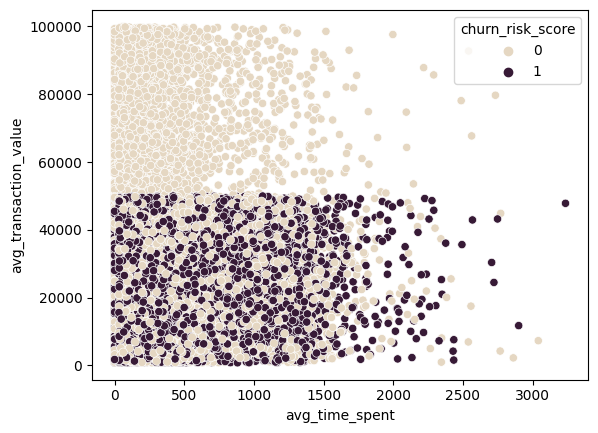

In [30]:
#shows correlation between time spent and transaction value
sns.scatterplot(data=df, x=df['avg_time_spent'], y=df['avg_transaction_value'], hue=df['churn_risk_score'], palette='ch:.25')

based on the scatterplot graph, it shows that there is no correlation between the average time spent on website and the average amount of transactions made by customers. however, customers who have risk in churn, only spent under $50.000 on our store.

We want to see how is the distribution of customer's churn.

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

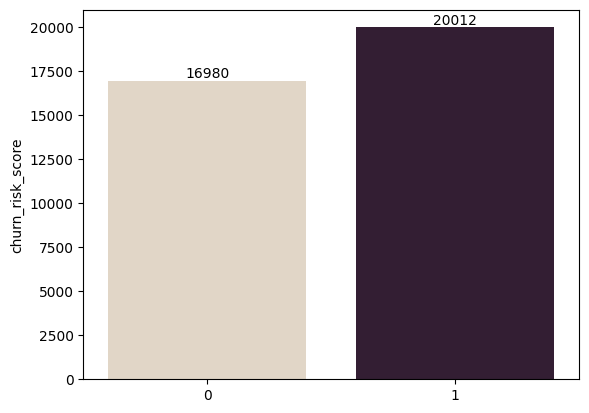

In [31]:
#distribution plot of churn
cs = sns.barplot(data=df, x=df['churn_risk_score'].unique(), y=df['churn_risk_score'].value_counts(), palette='ch:.25')
plt.bar_label(cs.containers[0])
plt.xticks()

the data is balanced, which means that the distribution between customers who churn and do not churn is quite equal. next, we eill examine more about the churn customer

### **churn customer**

In [32]:
#query churn customer dataframe
dfchurn = df.loc[df['churn_risk_score'] == 1]

(array([0, 1, 2, 3]),
 [Text(0, 0, 'No Membership'),
  Text(1, 0, 'Basic Membership'),
  Text(2, 0, 'Gold Membership'),
  Text(3, 0, 'Silver Membership')])

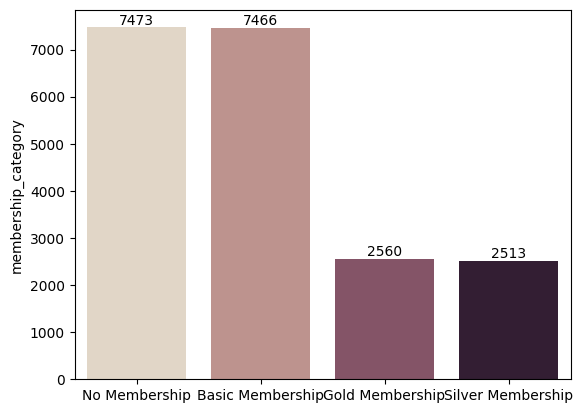

In [33]:
#membership distribution from churn customer
m = sns.barplot(data=dfchurn, x=dfchurn['membership_category'].unique(), y=dfchurn['membership_category'].value_counts(), palette='ch:.25')
plt.bar_label(m.containers[0])
plt.xticks()

The majority of customers who have risk in churn didn't have membership and have basic membership.

<Axes: xlabel='avg_transaction_value', ylabel='Count'>

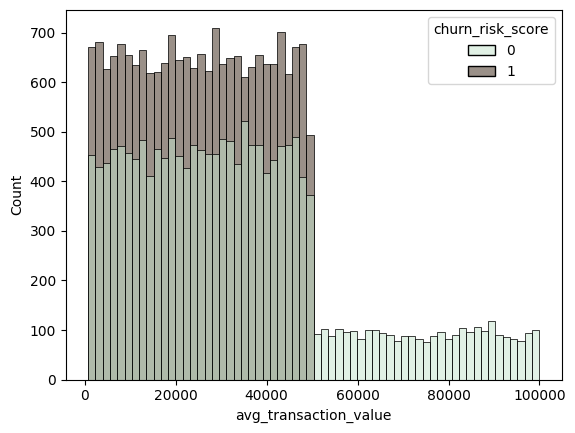

In [34]:
#shows distribution of average transaction value
sns.histplot(data=df, x=df['avg_transaction_value'], hue=df['churn_risk_score'], palette = 'ch:25')

the histogram graph shows that customers who have risk in churn, didn't spent more than 50.000 dollars. Meanwhile, the other spent more than $50000 and some of them spent 100.000 dollars. this means that the more loyal customers are, the more money they spent

<Axes: xlabel='days_since_last_login', ylabel='Count'>

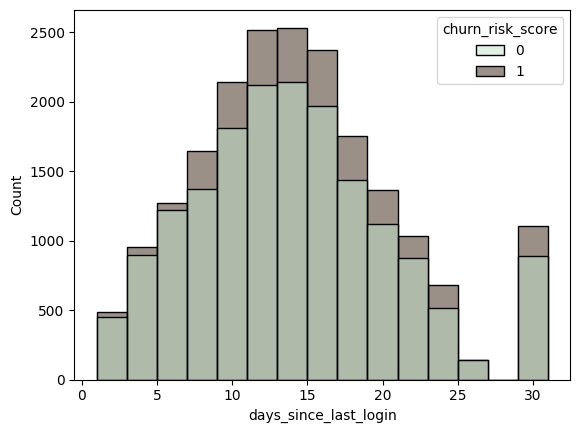

In [35]:
#shows distribution of days since last login
sns.histplot(data=df, x=df.days_since_last_login, hue=df.churn_risk_score, bins=15, palette='ch:25')

customers who have risks in churn are not opening our website longer than those who don't have risks in churn. it means that the longer they not opening the website, the higher risk of churn.

(array([0, 1]), [Text(0, 0, 'F'), Text(1, 0, 'M')])

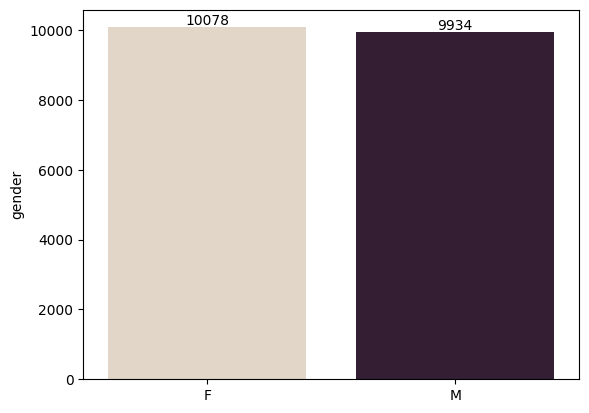

In [36]:
#shows distribution of gender
g = sns.barplot(data=dfchurn, x=dfchurn['gender'].unique(), y=dfchurn['gender'].value_counts(), palette='ch:.25')
plt.bar_label(g.containers[0])
plt.xticks()

from the graph above, it shows that there are no specific difference between gender in churning risks

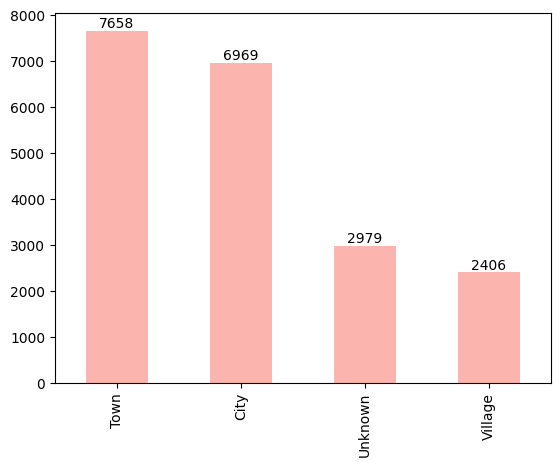

In [37]:
#shows distribution of region
ax = dfchurn['region_category'].value_counts().plot(kind='bar', cmap='Pastel1')
ax.bar_label(ax.containers[0], fmt='%.0f');

most of our customers who have risks in churn, are from `Town` and `City`. but this cannot be used as a reference to create marketing promotion because most of our customers are from `Town` and `City`.

(array([0, 1]), [Text(0, 0, 'Yes'), Text(1, 0, 'No')])

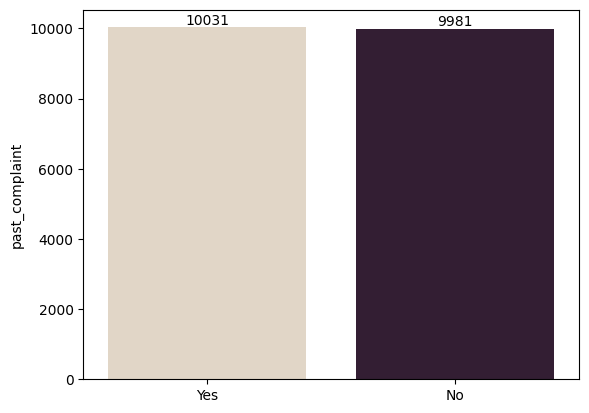

In [38]:
#shows distribution of past complain
pc = sns.barplot(data=dfchurn, x=dfchurn['past_complaint'].unique(), y=dfchurn['past_complaint'].value_counts(), palette='ch:.25')
plt.bar_label(pc.containers[0])
plt.xticks()

there is no significance difference between customers who submit complaints and not in churning risks

<Axes: xlabel='points_in_wallet', ylabel='Count'>

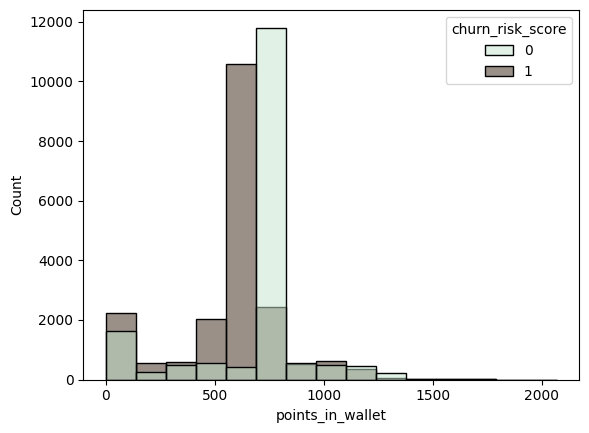

In [39]:
#shows distribution of points
sns.histplot(data=df, x=df.points_in_wallet, bins=15, hue=df.churn_risk_score, palette='ch:25')

the graph shows that there are no significance difference between customers who have more points or not in churning risks. The points distribution between customers are quite equal.

# **Feature Engineering**

## Feature Selection

In [40]:
# melihat korelasi antar kolom
%%time
plot_correlation_matrix(df.phik_matrix().values,
                        x_labels=df.phik_matrix().columns,
                        y_labels=df.phik_matrix().index,
                        vmin=0, vmax=1, color_map="Oranges",
                        title=r"Korelasi Antar Kolom",
                        fontsize_factor=1.5,
                        figsize=(20, 8))
plt.tight_layout()


UsageError: Line magic function `%%time` not found.


The Phik Matrix Correlation shows that with tresshold=0.1, columns which has correlation with `churn_risk_score` are `membership_category`,`avg_transaction_value`, `avg_frequency_login_days`, `points_in_wallet`, `feedback`. Hence we will create new df with selected feature.

In [41]:
#create new data frame
dfnew = df[['membership_category','avg_transaction_value','avg_frequency_login_days','points_in_wallet','feedback','churn_risk_score']]

### Cardinality

check cardinality of categorical features

In [42]:
cat = dfnew[['membership_category','feedback']]
for i in cat:
    print(i)
    print('category:', cat[i].nunique())
    print('-'*30)

membership_category
category: 6
------------------------------
feedback
category: 3
------------------------------


we will not handle the cardinality due to the number of values of each columns are below 10.

### VIF

check VIF value for numerical category

In [43]:
num = dfnew[['avg_transaction_value','avg_frequency_login_days','points_in_wallet']]

def vifcalculation(df):

    # calculate
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

vifcalculation(num)

,variables,VIF
0,avg_transaction_value,2.598410
1,avg_frequency_login_days,2.484646
2,points_in_wallet,3.497848


we will not handle VIF in numerical columns due to the number of values of each columns are below 5.

## Split

In [44]:
#Split feature and target
X = dfnew.drop(['churn_risk_score'], axis=1)
y = dfnew['churn_risk_score']

In [45]:
#define x and y train-test-val
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)

## Outllier Overview

to see if there any outliers and choose outlier handling method, we will shows skewness value from histogram plot and boxplot.

In [46]:
#function of data distribution
def diagnostic_plots(dfnewest, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(dfnewest[variable], bins=30, color='antiquewhite')
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=dfnewest[variable], color='tan')
    plt.title('Boxplot')

    plt.show()


avg_transaction_value


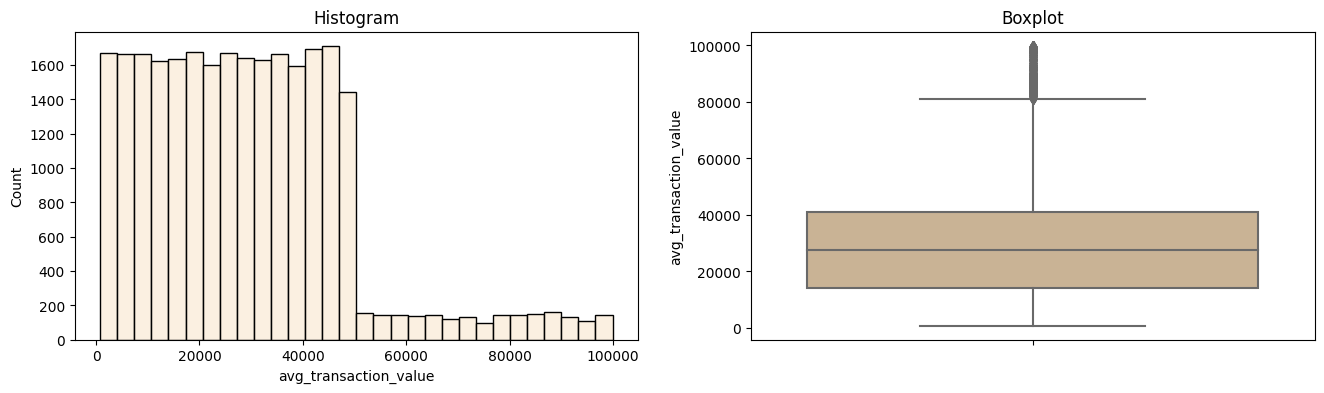


Skewness Value :  1.0025379896125688

avg_frequency_login_days


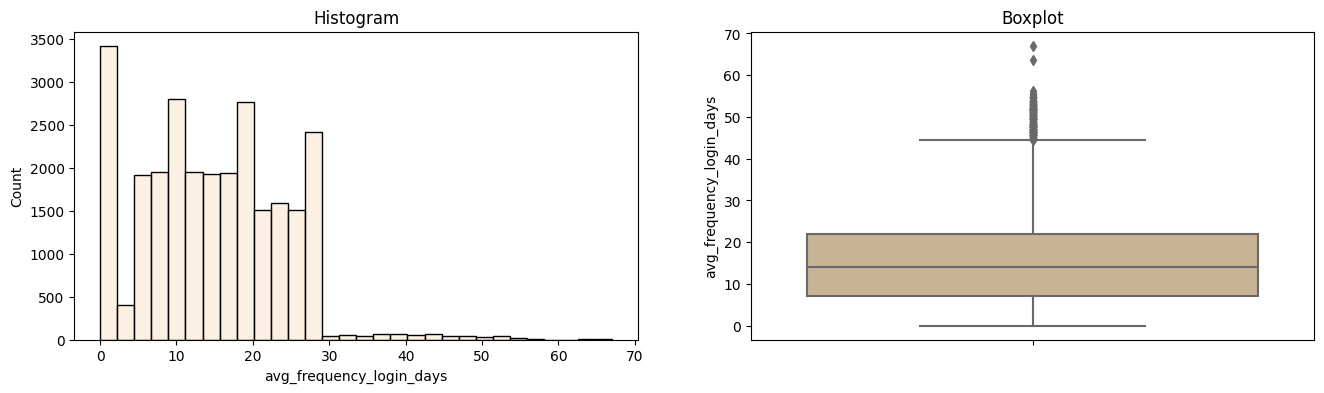


Skewness Value :  0.388169403934923

points_in_wallet


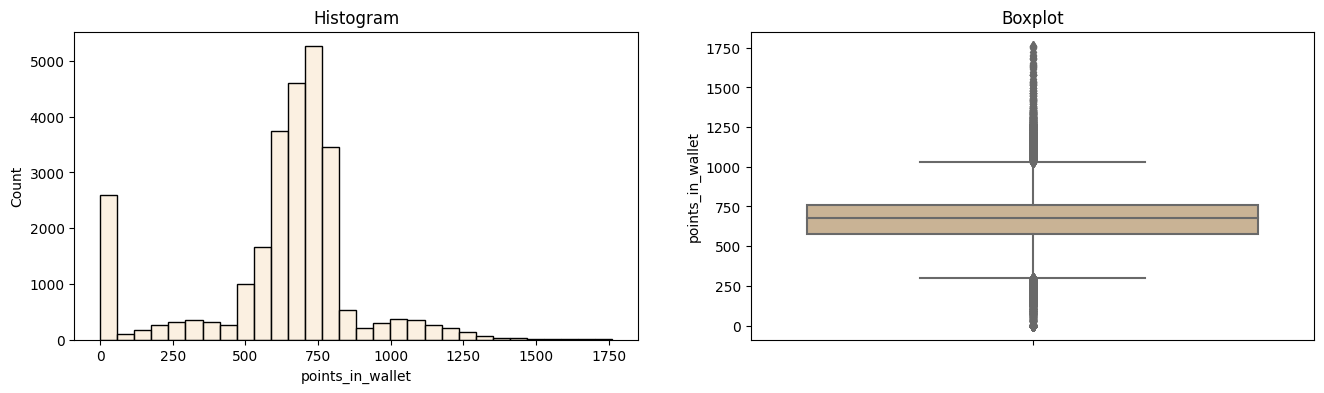


Skewness Value :  -0.7713017051281392


In [47]:
#avg_transaction_value distribution
print('\navg_transaction_value')
diagnostic_plots(X_train, 'avg_transaction_value')
print('\nSkewness Value : ', X_train['avg_transaction_value'].skew())

#avg_frequency_login_days distribution
print('\navg_frequency_login_days')
diagnostic_plots(X_train, 'avg_frequency_login_days')
print('\nSkewness Value : ', X_train['avg_frequency_login_days'].skew())

#points_in_wallet distribution
print('\npoints_in_wallet')
diagnostic_plots(X_train, 'points_in_wallet')
print('\nSkewness Value : ', X_train['points_in_wallet'].skew())

all of the numerical category skewness are below 1 and all of it has outliers, furthermore we will handle the outlier using gaussian method and scale using Standard Scaler.

## Pipeline preprocessing

In [48]:
#numerical preprocessing
#transaction value
numpipe = Pipeline([
        ('outlier', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
        ('scaler', StandardScaler())
    ])
num_train = numpipe.fit_transform(X_train[['avg_transaction_value','avg_frequency_login_days','points_in_wallet']])


#categorical preprocessing
#membership category
membershippipe = Pipeline([
        ('encoder_ord', OrdinalEncoder(categories=[['No Membership', 'Basic Membership', 'Premium Membership','Silver Membership', 'Gold Membership', 'Platinum Membership']]))
    ])
membership_train = membershippipe.fit_transform(X_train[['membership_category']])

#feedback
feedbackpipe = Pipeline([
        ('encoder_ord', OrdinalEncoder(categories=[['Negative', 'No reason specified', 'Positive']]))
    ])
feedback_train = feedbackpipe.fit_transform(X_train[['feedback']])

In [49]:
#transform
full_pipeline = ColumnTransformer([
        ("num", numpipe, ['avg_transaction_value','avg_frequency_login_days','points_in_wallet']),
        ("membership", membershippipe, ['membership_category']),
        ("feedb",feedbackpipe, ['feedback'])
    ])

train_processed = full_pipeline.fit_transform(X_train)

In [50]:
#train test and validation
test_processed = full_pipeline.transform(X_test)
val_processed = full_pipeline.transform(X_val)

Create pipeline for modelling process using TensorFlow Pipeline

In [51]:
#pipeline ETL tensorflow
train_set = tf.data.Dataset.from_tensor_slices((train_processed, y_train))

#shuffle train set
train_set = train_set.shuffle(buffer_size=712).batch(64)

#val dataset
val_set = tf.data.Dataset.from_tensor_slices((val_processed, y_val))
val_set = val_set.batch(64)

#test dataset
test_set = tf.data.Dataset.from_tensor_slices((test_processed, y_test)).batch(64)


# **Model**

### **Sequential**

In [52]:
alp = 10
inp = X_train.shape[1]
out = 1
hid = int(len(X_train)/(alp*(inp+out)))
print(f'Jumlah neuron pada hidden layer: {hid}')

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(inp, activation='relu', input_shape=(inp,)),
    tf.keras.layers.Dense(hid, activation='relu'),
    tf.keras.layers.Dense(out, activation='sigmoid')
])

model.summary()

Jumlah neuron pada hidden layer: 443
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 443)               2658      
                                                                 
 dense_2 (Dense)             (None, 1)                 444       
                                                                 
Total params: 3132 (12.23 KB)
Trainable params: 3132 (12.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
#model definition
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics='accuracy')

In [54]:
#shows architecture
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


in this sequential model, it has 2 hidden layer, with 3132 total parameters. the activation used in this model is `relu` in input and hidden layer and `sigmoid` in output layer.

In [55]:
#model training
history = model.fit((train_set), epochs=100, batch_size=6144, validation_data=(val_set))

Epoch 1/100


417/417 [==============================] - 7s 8ms/step - loss: 0.4440 - accuracy: 0.7749 - val_loss: 0.3912 - val_accuracy: 0.7883
Epoch 2/100
417/417 [==============================] - 3s 7ms/step - loss: 0.3689 - accuracy: 0.8040 - val_loss: 0.3491 - val_accuracy: 0.8187
Epoch 3/100
417/417 [==============================] - 3s 7ms/step - loss: 0.3349 - accuracy: 0.8421 - val_loss: 0.3161 - val_accuracy: 0.8922
Epoch 4/100
417/417 [==============================] - 3s 6ms/step - loss: 0.2956 - accuracy: 0.8878 - val_loss: 0.2764 - val_accuracy: 0.9042
Epoch 5/100
417/417 [==============================] - 3s 7ms/step - loss: 0.2671 - accuracy: 0.9015 - val_loss: 0.2527 - val_accuracy: 0.9079
Epoch 6/100
417/417 [==============================] - 3s 7ms/step - loss: 0.2466 - accuracy: 0.9055 - val_loss: 0.2390 - val_accuracy: 0.9109
Epoch 7/100
417/417 [==============================] - 3s 7ms/step - loss: 0.2336 - accuracy: 0.9095 - val_loss: 0.2240 - val_accuracy: 0.9140
Epoch 8/100

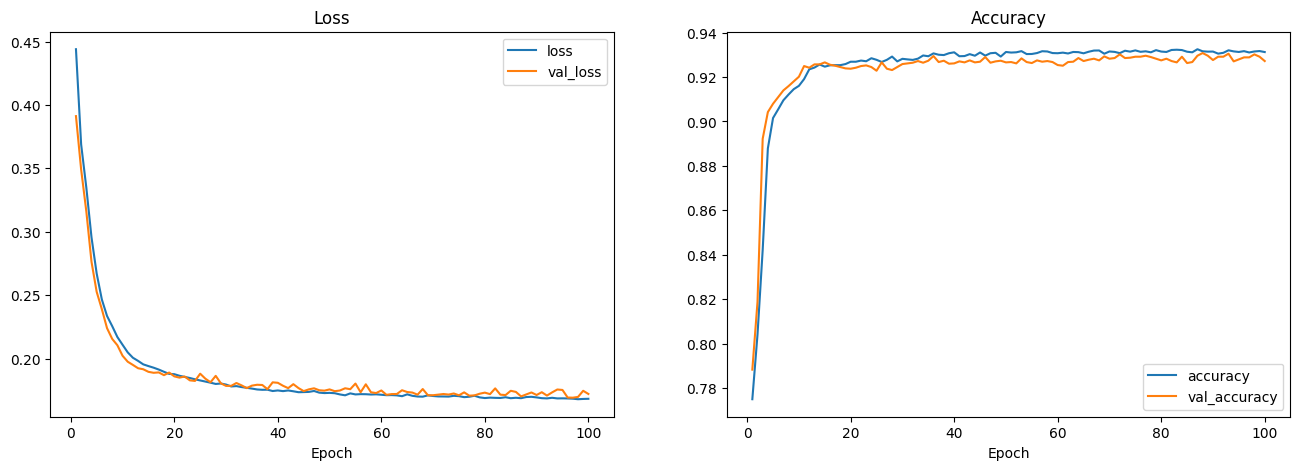

In [56]:
#show evaluation graph
epoch=100

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

this model has bestfit performace. from the loss graph, the validation score is under the train score. and from the accuracy graph, the valisation score is above the rain score. the line graph shows that the model has explotion but not significant so we will not handle the explotion.

In [57]:
#train evaluation
train_loss, train_acc = model.evaluate(train_set)
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_acc:.4f}')

#test evaluation
test_loss, test_acc = model.evaluate(test_set)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

 72/417 [====>.........................] - ETA: 1s - loss: 0.1716 - accuracy: 0.9319

417/417 [==============================] - 1s 3ms/step - loss: 0.1687 - accuracy: 0.9309
Train loss: 0.1687
Train accuracy: 0.9309
58/58 [==============================] - 0s 2ms/step - loss: 0.1693 - accuracy: 0.9316
Test loss: 0.1693
Test accuracy: 0.9316


this model has 93% accuracy from train and test data, and has goodfit performance.

417/417 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.43      0.44     12225
           1       0.54      0.57      0.55     14408

    accuracy                           0.50     26633
   macro avg       0.50      0.50      0.50     26633
weighted avg       0.50      0.50      0.50     26633



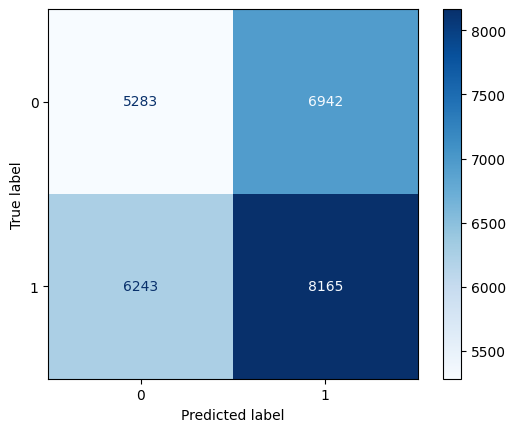

In [58]:
# Model Evaluation of train-set

y_pred_train = model.predict(train_set)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)

print(classification_report(y_train, y_pred_train))

# confusion matrix

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

58/58 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1698
           1       0.92      0.96      0.94      2002

    accuracy                           0.93      3700
   macro avg       0.93      0.93      0.93      3700
weighted avg       0.93      0.93      0.93      3700



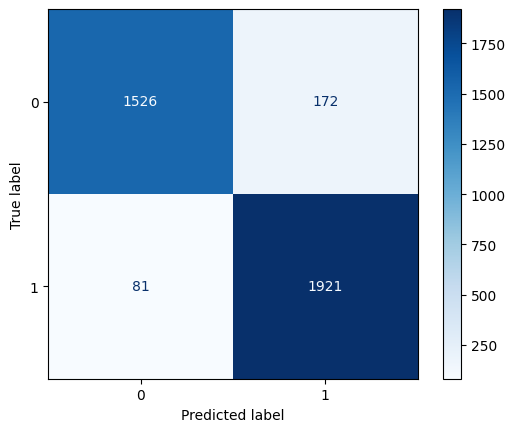

In [59]:
# Model Evaluation of test-set

y_pred_test = model.predict(test_set)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_test))

# confusion matrix

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

after we predicted using the sequential model, on the train set the model can predict with 50% accuracy, but on the test set, it can predict with 94% accuracy. It means that the model has underfit for the prediction. To make a better model, we will tine some hyperparameter in this model.

#### Improvement

In [60]:
#hyperparameter tuning
model_imp = Sequential()
model_imp.add(Dense(64, input_shape = (inp,), activation = 'relu'))
model_imp.add(Dropout(0.3))
model_imp.add(Dense(64, activation = 'relu'))
model_imp.add(Dropout(0.3))
model_imp.add(Dense(1, activation = 'sigmoid'))

In [61]:
#model definition
model_imp.compile(loss='binary_crossentropy',optimizer='Adam',metrics='accuracy')

In [62]:
#shows architecture
tf.keras.utils.plot_model(model_imp, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [63]:
#model training
history_imp = model_imp.fit((train_set), epochs=100, batch_size=6144, validation_data=(val_set))

Epoch 1/100


417/417 [==============================] - 3s 4ms/step - loss: 0.4378 - accuracy: 0.7926 - val_loss: 0.3595 - val_accuracy: 0.8299
Epoch 2/100
417/417 [==============================] - 1s 3ms/step - loss: 0.3622 - accuracy: 0.8286 - val_loss: 0.3350 - val_accuracy: 0.8512
Epoch 3/100
417/417 [==============================] - 1s 3ms/step - loss: 0.3341 - accuracy: 0.8451 - val_loss: 0.3003 - val_accuracy: 0.8769
Epoch 4/100
417/417 [==============================] - 1s 3ms/step - loss: 0.3040 - accuracy: 0.8740 - val_loss: 0.2578 - val_accuracy: 0.9061
Epoch 5/100
417/417 [==============================] - 1s 4ms/step - loss: 0.2726 - accuracy: 0.8966 - val_loss: 0.2290 - val_accuracy: 0.9185
Epoch 6/100
417/417 [==============================] - 1s 3ms/step - loss: 0.2496 - accuracy: 0.9068 - val_loss: 0.2135 - val_accuracy: 0.9215
Epoch 7/100
417/417 [==============================] - 1s 3ms/step - loss: 0.2345 - accuracy: 0.9127 - val_loss: 0.1998 - val_accuracy: 0.9245
Epoch 8/100

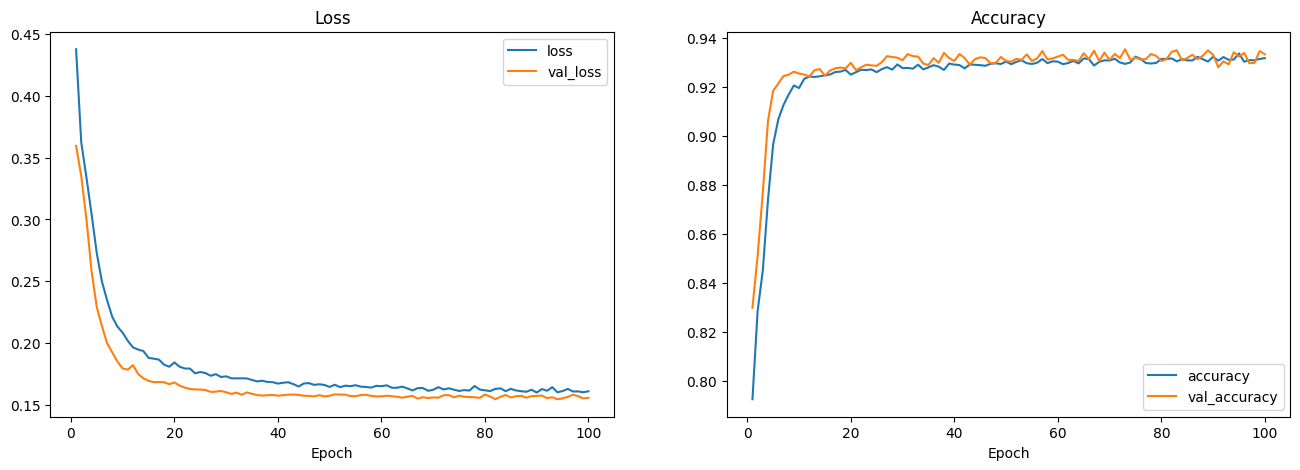

In [64]:
#show evaluation graph
epoch=100

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history_imp.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history_imp.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history_imp.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history_imp.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

In [65]:
#train evaluation
train_imp_loss, train_imp_acc = model_imp.evaluate(train_set)
print(f'Train_imp loss: {train_imp_loss:.4f}')
print(f'Train_imp accuracy: {train_imp_acc:.4f}')

#test evaluation
test_imp_loss, test_imp_acc = model_imp.evaluate(test_set)
print(f'Test loss: {test_imp_loss:.4f}')
print(f'Test accuracy: {test_imp_acc:.4f}')

 55/417 [==>...........................] - ETA: 1s - loss: 0.1532 - accuracy: 0.9330

417/417 [==============================] - 1s 2ms/step - loss: 0.1509 - accuracy: 0.9347
Train_imp loss: 0.1509
Train_imp accuracy: 0.9347
58/58 [==============================] - 0s 2ms/step - loss: 0.1503 - accuracy: 0.9332
Test loss: 0.1503
Test accuracy: 0.9332


 39/417 [=>............................] - ETA: 1s

417/417 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.46      0.46     12225
           1       0.54      0.54      0.54     14408

    accuracy                           0.50     26633
   macro avg       0.50      0.50      0.50     26633
weighted avg       0.50      0.50      0.50     26633



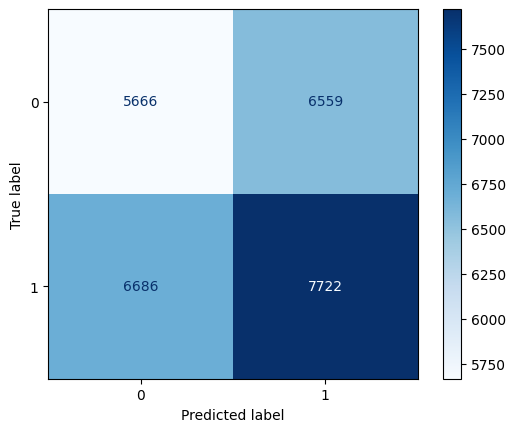

In [66]:
# Model Evaluation of train-set

y_pred_imp_train = model_imp.predict(train_set)
y_pred_imp_train = np.where(y_pred_imp_train >= 0.5, 1, 0)

print(classification_report(y_train, y_pred_imp_train))

# confusion matrix

cm = confusion_matrix(y_train, y_pred_imp_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

58/58 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1698
           1       0.95      0.93      0.94      2002

    accuracy                           0.93      3700
   macro avg       0.93      0.93      0.93      3700
weighted avg       0.93      0.93      0.93      3700



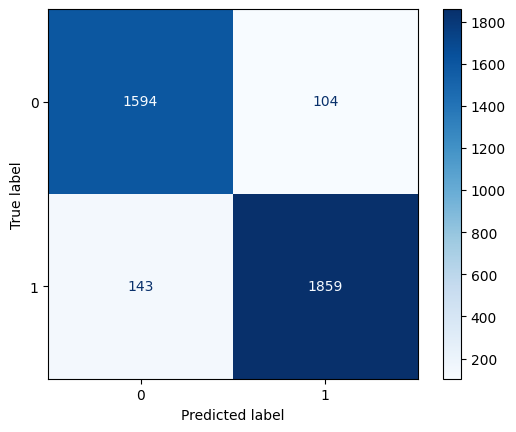

In [67]:
# Model Evaluation of test-set

y_pred_imp_test = model_imp.predict(test_set)
y_pred_imp_test = np.where(y_pred_imp_test >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_imp_test))

# confusion matrix

cm = confusion_matrix(y_test, y_pred_imp_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

After we did some hyperparameter tuning, the accuracy score is decreased. It means that the default model is better than the hypertuned model.

### **Functional**

In [68]:
# functional API
input_layer= tf.keras.Input(shape=(train_processed.shape[1:]),name='input_layer')

hidden_1= Dense(30, activation='relu', name='hidden_1')(input_layer)
hidden_2= Dense(30, activation='relu', name='hidden_2')(hidden_1)
hidden_3= Dense(10, activation='relu', name='hidden_3')(hidden_2)
concat= tf.keras.layers.concatenate([input_layer,hidden_3])

output_layer= Dense(1, activation='sigmoid', name='output_layer')(concat)

modelf= Model(inputs=input_layer,
                  outputs=output_layer)

modelf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
modelf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 5)]                  0         []                            
                                                                                                  
 hidden_1 (Dense)            (None, 30)                   180       ['input_layer[0][0]']         
                                                                                                  
 hidden_2 (Dense)            (None, 30)                   930       ['hidden_1[0][0]']            
                                                                                                  
 hidden_3 (Dense)            (None, 10)                   310       ['hidden_2[0][0]']            
                                                                                              

In [70]:
#model definition
modelf.compile(loss='binary_crossentropy',optimizer='Adam',metrics='accuracy')

In [71]:
#shows architecture
tf.keras.utils.plot_model(modelf, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


in this sequential model, it has 4 hidden layer, with 1436 total parameters. the activation used in this model is `relu` in input and hidden layer and `sigmoid` in output layer.

In [72]:
#model training
historyf = modelf.fit((train_set), epochs=100, batch_size=6144, validation_data=(val_set))

Epoch 1/100


417/417 [==============================] - 3s 3ms/step - loss: 0.4251 - accuracy: 0.7787 - val_loss: 0.3549 - val_accuracy: 0.8235
Epoch 2/100
417/417 [==============================] - 1s 3ms/step - loss: 0.3287 - accuracy: 0.8523 - val_loss: 0.3046 - val_accuracy: 0.8868
Epoch 3/100
417/417 [==============================] - 1s 3ms/step - loss: 0.2805 - accuracy: 0.8921 - val_loss: 0.2585 - val_accuracy: 0.9070
Epoch 4/100
417/417 [==============================] - 1s 3ms/step - loss: 0.2378 - accuracy: 0.9107 - val_loss: 0.2237 - val_accuracy: 0.9197
Epoch 5/100
417/417 [==============================] - 1s 3ms/step - loss: 0.2136 - accuracy: 0.9183 - val_loss: 0.2064 - val_accuracy: 0.9207
Epoch 6/100
417/417 [==============================] - 1s 3ms/step - loss: 0.1966 - accuracy: 0.9219 - val_loss: 0.1917 - val_accuracy: 0.9260
Epoch 7/100
417/417 [==============================] - 1s 3ms/step - loss: 0.1857 - accuracy: 0.9252 - val_loss: 0.1911 - val_accuracy: 0.9243
Epoch 8/100

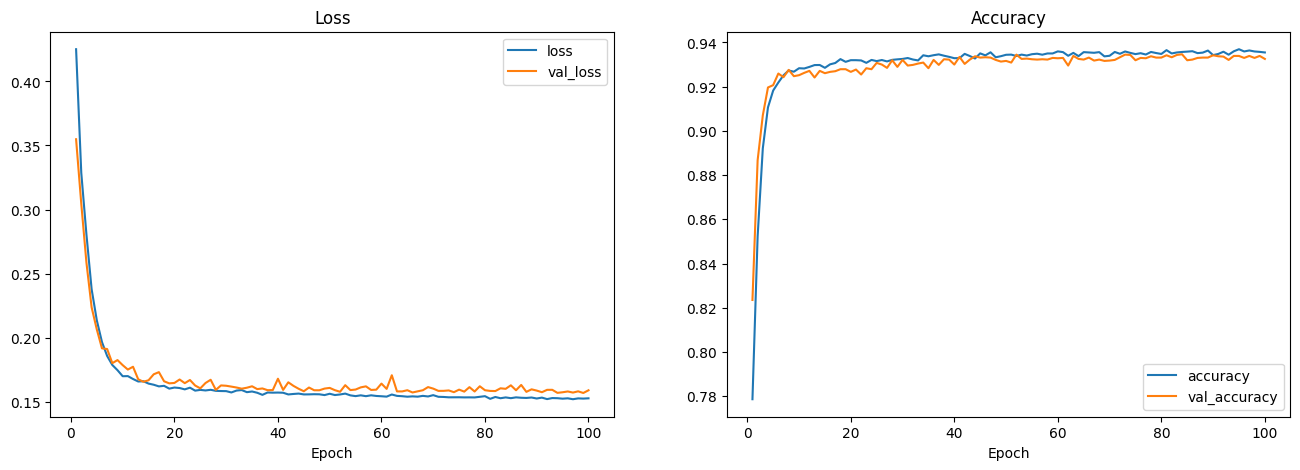

In [73]:
#show evaluation graph
epoch=100

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),historyf.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),historyf.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),historyf.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),historyf.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

this model has bestfit performace. from the loss graph, the validation score is under the train score. and from the accuracy graph, the valisation score is above the rain score. the line graph shows that the model has explotion but not significant so we will not handle the explotion.

In [74]:
#train evaluation
trainf_loss, trainf_acc = modelf.evaluate(train_set)
print(f'Trainf loss: {trainf_loss:.4f}')
print(f'Trainf accuracy: {trainf_acc:.4f}')

#test evaluation
testf_loss, testf_acc = modelf.evaluate(test_set)
print(f'Testf loss: {testf_loss:.4f}')
print(f'Testf accuracy: {testf_acc:.4f}')

 54/417 [==>...........................] - ETA: 1s - loss: 0.1556 - accuracy: 0.9332

417/417 [==============================] - 1s 2ms/step - loss: 0.1521 - accuracy: 0.9350
Trainf loss: 0.1521
Trainf accuracy: 0.9350
58/58 [==============================] - 0s 2ms/step - loss: 0.1555 - accuracy: 0.9319
Testf loss: 0.1555
Testf accuracy: 0.9319


this model has 93.5% accuracy from train and test data 93%, and has overfit performance

 20/417 [>.............................] - ETA: 1s 

417/417 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.46      0.46     12225
           1       0.54      0.54      0.54     14408

    accuracy                           0.51     26633
   macro avg       0.50      0.50      0.50     26633
weighted avg       0.51      0.51      0.51     26633



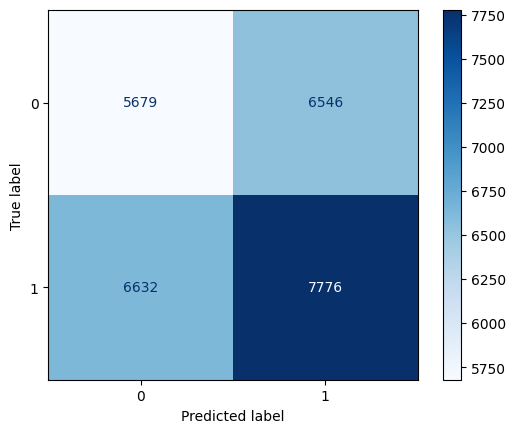

In [75]:
# Model Evaluation of train-set

y_predf_train = modelf.predict(train_set)
y_predf_train = np.where(y_predf_train >= 0.5, 1, 0)

print(classification_report(y_train, y_predf_train))

# confusion matrix

cm = confusion_matrix(y_train, y_predf_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

58/58 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1698
           1       0.94      0.93      0.94      2002

    accuracy                           0.93      3700
   macro avg       0.93      0.93      0.93      3700
weighted avg       0.93      0.93      0.93      3700



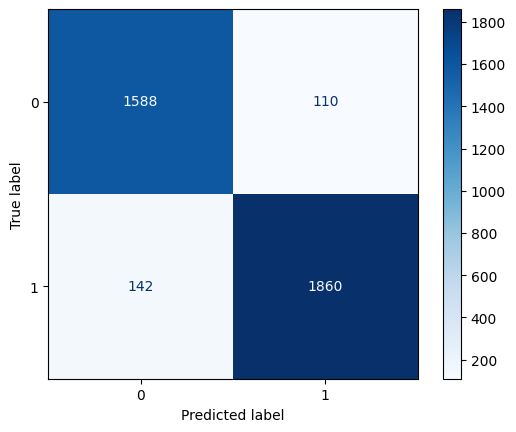

In [76]:
# Model Evaluation of test-set

y_predf_test = modelf.predict(test_set)
y_predf_test = np.where(y_predf_test >= 0.5, 1, 0)

print(classification_report(y_test, y_predf_test))

# confusion matrix

cm = confusion_matrix(y_test, y_predf_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

after we predicted using the sequential model, on the train set the model can predict with 51% accuracy, but on the test set, it can predict with 93% accuracy. It means that the model has underfit for the prediction. To make a better model, we will tine some hyperparameter in this model.

####Improvement

In [77]:
input_layer= tf.keras.Input(shape=(train_processed.shape[1:]),name='input_layer')

hidden_1_imp= Dense(60, activation='relu', name='hidden_1_imp')(input_layer)
dropout_layer1 = Dropout(0.3)(hidden_1_imp)
hidden_2_imp= Dense(30, activation='relu', name='hidden_2_imp')(dropout_layer1)
dropout_layer2 = Dropout(0.3)(hidden_2_imp)
hidden_3_imp= Dense(10, activation='relu', name='hidden_3_imp')(dropout_layer2)
concat= tf.keras.layers.concatenate([input_layer,hidden_3_imp])

output_layer= Dense(1, activation='sigmoid', name='output_layer')(concat)

modelf_imp= Model(inputs=input_layer,
                  outputs=output_layer)


In [78]:
modelf_imp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 5)]                  0         []                            
                                                                                                  
 hidden_1_imp (Dense)        (None, 60)                   360       ['input_layer[0][0]']         
                                                                                                  
 dropout_2 (Dropout)         (None, 60)                   0         ['hidden_1_imp[0][0]']        
                                                                                                  
 hidden_2_imp (Dense)        (None, 30)                   1830      ['dropout_2[0][0]']           
                                                                                            

In [79]:
#model definition
modelf_imp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [80]:
#shows architecture
tf.keras.utils.plot_model(modelf_imp, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [81]:
#model training
historyf_imp = modelf_imp.fit((train_set), epochs=100, batch_size=6144, validation_data=(val_set))

Epoch 1/100


417/417 [==============================] - 4s 4ms/step - loss: 0.4552 - accuracy: 0.7830 - val_loss: 0.3753 - val_accuracy: 0.8261
Epoch 2/100
417/417 [==============================] - 1s 3ms/step - loss: 0.3779 - accuracy: 0.8135 - val_loss: 0.3458 - val_accuracy: 0.8390
Epoch 3/100
417/417 [==============================] - 2s 4ms/step - loss: 0.3559 - accuracy: 0.8271 - val_loss: 0.3313 - val_accuracy: 0.8455
Epoch 4/100
417/417 [==============================] - 1s 3ms/step - loss: 0.3397 - accuracy: 0.8372 - val_loss: 0.3116 - val_accuracy: 0.8467
Epoch 5/100
417/417 [==============================] - 1s 3ms/step - loss: 0.3134 - accuracy: 0.8648 - val_loss: 0.2633 - val_accuracy: 0.9072
Epoch 6/100
417/417 [==============================] - 2s 4ms/step - loss: 0.2788 - accuracy: 0.8940 - val_loss: 0.2332 - val_accuracy: 0.9203
Epoch 7/100
417/417 [==============================] - 1s 3ms/step - loss: 0.2544 - accuracy: 0.9082 - val_loss: 0.2176 - val_accuracy: 0.9240
Epoch 8/100

Text(0.5, 0, 'Epoch')

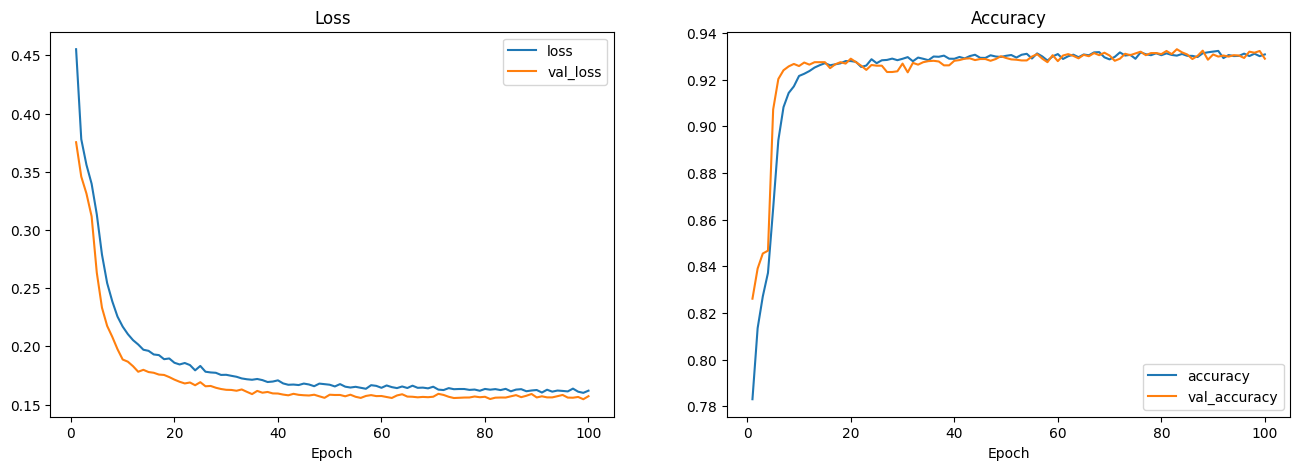

In [82]:
#show evaluation graph
epoch=100

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),historyf_imp.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),historyf_imp.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),historyf_imp.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),historyf_imp.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)


In [83]:
#train evaluation
trainf_imp_loss, trainf_imp_acc = modelf_imp.evaluate(train_set)
print(f'Trainf_imp loss: {trainf_imp_loss:.4f}')
print(f'Trainf_imp accuracy: {trainf_imp_acc:.4f}')

#test evaluation
testf_imp_loss, testf_imp_acc = modelf_imp.evaluate(test_set)
print(f'Testf_imp loss: {testf_imp_loss:.4f}')
print(f'Testf_imp accuracy: {testf_imp_acc:.4f}')

129/417 [========>.....................] - ETA: 1s - loss: 0.1537 - accuracy: 0.9319

417/417 [==============================] - 3s 7ms/step - loss: 0.1527 - accuracy: 0.9340
Trainf_imp loss: 0.1527
Trainf_imp accuracy: 0.9340
58/58 [==============================] - 1s 10ms/step - loss: 0.1525 - accuracy: 0.9295
Testf_imp loss: 0.1525
Testf_imp accuracy: 0.9295


 33/417 [=>............................] - ETA: 2s

417/417 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.46      0.49      0.47     12225
           1       0.54      0.52      0.53     14408

    accuracy                           0.50     26633
   macro avg       0.50      0.50      0.50     26633
weighted avg       0.51      0.50      0.50     26633



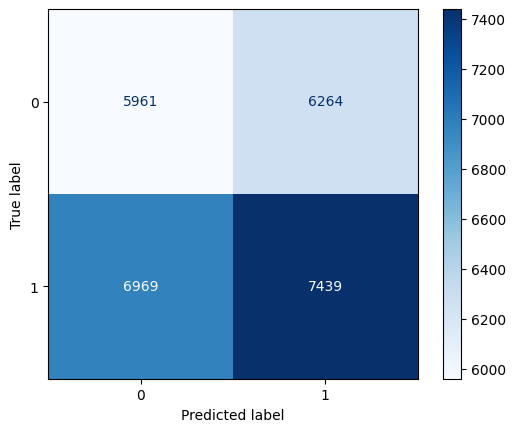

In [84]:
# Model Evaluation of train-set

y_predf_imp_train = modelf_imp.predict(train_set)
y_predf_imp_train = np.where(y_predf_imp_train >= 0.5, 1, 0)

print(classification_report(y_train, y_predf_imp_train))

# confusion matrix

cm = confusion_matrix(y_train, y_predf_imp_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

58/58 [==============================] - 0s 6ms/step


              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1698
           1       0.96      0.90      0.93      2002

    accuracy                           0.93      3700
   macro avg       0.93      0.93      0.93      3700
weighted avg       0.93      0.93      0.93      3700



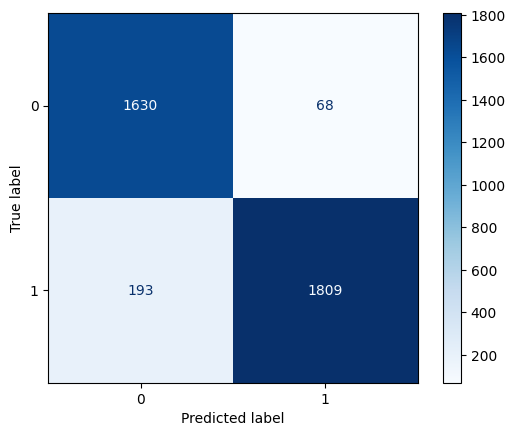

In [85]:
# Model Evaluation of test-set

y_predf_imp_test = modelf_imp.predict(test_set)
y_predf_imp_test = np.where(y_predf_imp_test >= 0.5, 1, 0)

print(classification_report(y_test, y_predf_imp_test))

# confusion matrix

cm = confusion_matrix(y_test, y_predf_imp_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Blues')
plt.show()

After we did some hyperparameter tuning, the accuracy score is increased. It means that the hypertuned model is better than the default model.

After looking at the comparison of the accuracy score of the 2 models and 2 improvements, the best model is the functional that has been improved. Hence for the inference, we will save and use functional improved model

# **Model Saving**

In [86]:
#save pipeline
with open('pipeline.pkl','wb') as file_1:
    joblib.dump(full_pipeline,file_1)

In [87]:
#save model
modelf_imp.save('modelf_imp_wq5.h5')

# Model Inference

In [88]:
#save inference dataframe to csv
inf.to_csv('inf.csv', index=False)

# **Conclusion**

The conclusion of the Deep Learning model training is that two types of models were implemented, namely Sequential and Functional models. After calculating the accuracy values for the training, testing, and validation datasets, it was found that the Functional model, which underwent hyperparameter tuning, performed the best among both.

The Sequential model, although simple and easy to implement, has limitations when dealing with complex problems. On the other hand, the Functional model provides greater flexibility in designing more complex network architectures tailored to the data requirements.

Furthermore, by utilizing hyperparameter tuning on the Functional model, we were able to enhance its performance by finding the optimal combination of hyperparameters. This allowed the model to generalize better to unseen data, leading to improved accuracy on the testing and validation datasets.

However, it is essential to consider that the process of hyperparameter tuning may require more time and resources. Therefore, in real-world implementations, a trade-off between model performance and complexity needs to be carefully evaluated.

In conclusion, the results of this learning experience demonstrate that when building Deep Learning models, the selection of the model type and hyperparameter tuning process are crucial steps to achieve optimal performance. The Functional model with hyperparameter tuning has proven to be a superior approach in this case, but further analysis is still necessary to address specific challenges and different issues.

Based on the analysis of the data and the insights gathered, here are some business insights and suggestions:

1. **Retention Strategy for Low-Spending Customers:** Customers who have a risk of churn tend to spend under $50,000 on the store. This finding suggests that there is a potential opportunity to focus on retaining these low-spending customers. Implement targeted marketing campaigns or loyalty programs to encourage them to increase their spending and strengthen their loyalty to the brand.

2. **Membership Upsell Strategy:** Majority of customers who have a risk of churn did not have a membership or only had basic membership. Consider implementing an upsell strategy to promote higher-tier memberships with additional benefits, as this may help in retaining customers by offering them more value and rewards.

3. **Targeted Engagement for Loyal Customers:** The histogram graph indicates that more loyal customers, who spend above $50,000 and sometimes even $100,000, are less likely to churn. Focus on engaging and rewarding these loyal customers to reinforce their loyalty further. Implement personalized offers, exclusive perks, or loyalty-based incentives to keep them engaged and committed to the brand.

4. **Churn Prediction and Re-Engagement:** The insight that longer periods of inactivity on the website are associated with a higher risk of churn suggests the need for proactive churn prediction and re-engagement strategies. Identify customers who show signs of inactivity and design targeted re-engagement campaigns to encourage them to return to the website and make purchases.

5. **Location-Based Strategies:** While there may not be a significant difference between towns and cities in terms of churn risk, it's still worth exploring location-based marketing strategies. Consider conducting customer surveys or analyzing customer preferences in different regions to identify unique needs and preferences that could inform localized marketing campaigns.

6. **Complaint Handling:** The analysis shows no significant difference in churn risk between customers who submit complaints and those who do not. However, it's essential to maintain a strong customer service approach to address complaints promptly and efficiently. Satisfied customers are more likely to remain loyal to the brand.

7. **Points System Optimization:** Since there is no significant difference in churn risk based on the points distribution, it may be beneficial to optimize the points system to increase customer engagement. Offer rewards or incentives that align with customer preferences and encourage them to earn and redeem points regularly.

Overall, the insights suggest a need for a multi-faceted approach to customer retention. By leveraging data-driven strategies, implementing personalized incentives, and focusing on customer engagement, the business can work towards reducing churn rates and fostering long-term customer loyalty. Continuously monitor customer behavior and feedback to fine-tune these strategies and adapt to changing customer preferences and needs.